In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import io
from PIL import Image

from tqdm import tqdm

from utils import generate_dataset

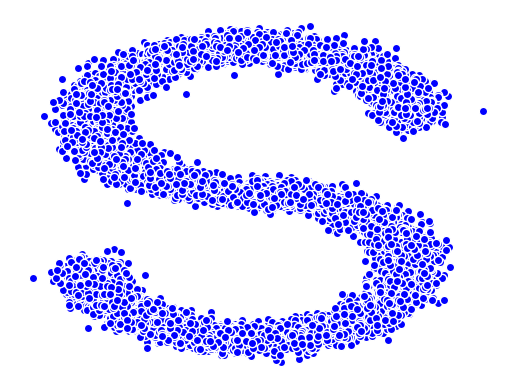

In [3]:
dataset = generate_dataset(10**4) # 生成数据集

In [4]:
# set values for parameters

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    '''
    :param schedule: 模式 
    :param n_timesteps: 步数
    :param start: 开始时的“学习率”
    :param end: 结束时的“学习率”
    :return: “学习率”序列/表格
    '''
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad": # 平方根
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


num_steps = 100 # 设置n_timesteps

# set methods for beta
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

In [5]:
# Calculate alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt

alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0) # 累计乘积
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0) # alphas_prod_p：创建一个新数组，它在 alphas_prod 前面添加了一个元素 1，使用 torch.cat 函数来连接。这样做是为了在计算时保持维度一致性？？？
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


实现 $x_t \textasciitilde {q(x_t|x_0)}$

In [6]:
# Forward process

# According to the provement, we can directly sample at any given timesteps (add noise)
# x[0] -> x[t]
def q_x(x_0,t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
C:\Users\24349\AppData\Local\Temp\ipykernel_7500\1975847469.py:13: SyntaxWarning: invalid escape sequence '\m'
  axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')


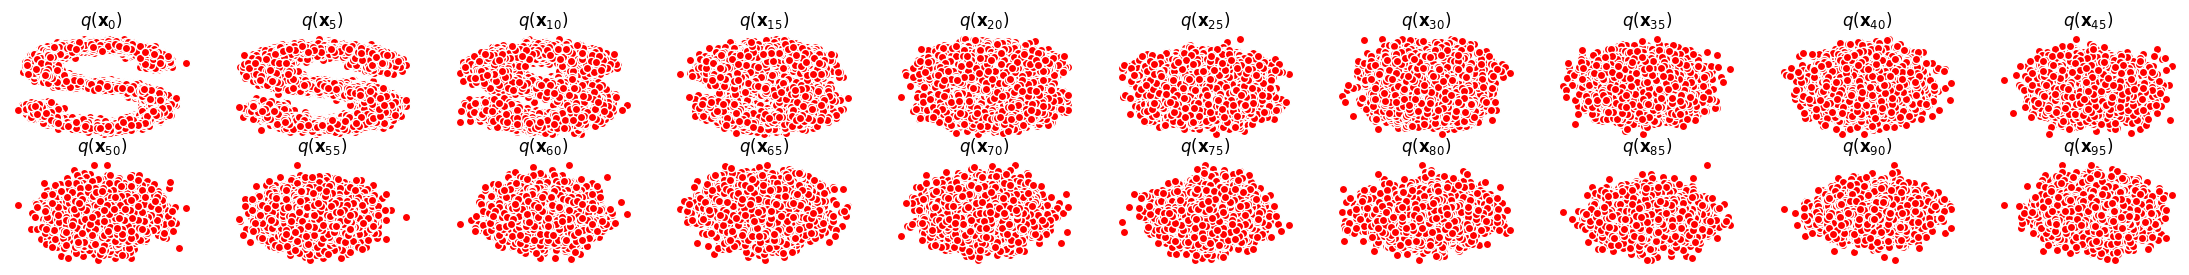

In [7]:
# show the results of forward process (when origin image add noise)
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

# total 100 steps, every 5 steps output 1 plot.
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows])) # x[t] 
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

In [8]:
# Reverse process

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()
        # 以下是线性层，但是维度没有改变？
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        # 使用 nn.ModuleList 来存储与时间步相关的嵌入层。每个嵌入层将时间步 t 映射到一个与 num_units 相同维度的向量。
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t):
        """ 
        生成的过程: 把t的值作为一个embedding,然后和x相加
        下边的循环等价于把每个nn.Embedding分别插入到每个nn.Linear之前
        从而产生predict noise
        这么做的理由是什么？把t加进来？只是加一层时间进来可不可以？
        """
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)

        return x


$p_\theta(x_{t-1}|x_t)$

$$
\Large
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_\theta(x_t,t)) + \sigma_t z 
$$

In [9]:
# Inference
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """from x[T] sampling"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x, t)

    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    sample = mean + sigma_t * z

    return (sample)

def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """from x[T] to x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape) # x[T]~Gauss 
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq # list of X_i

In [10]:
# loss function
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t
    t = torch.randint(0, n_steps, size=(batch_size // 2,)) # t的大小一定是 batch_size//2 吗？还是因为下面直接对称采样了
    t = torch.cat([t, n_steps - 1 - t], dim=0) # 对称操作然后拼接
    t = t.unsqueeze(-1) # 在最后一个维度上面扩张，此处是一维变成二维，保持原来维度上的数据不变，是否有必要呢？

    # x0的系数
    a = alphas_bar_sqrt[t] # 把升高维度的t用来索引？但是此处还是只用了t第一个元素？

    # eps的系数
    aml = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1)) # 这里又和unsqueeze抵消了？

    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

In [12]:
# Training model
seed = 1234

class EMA():
    """
    构建一个参数平滑器
    貌似只是一个技巧。而且在这里没有用上？
    """

    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average


print('Training model...')


batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')
device = 'cuda'
####################
model = MLPDiffusion(num_steps)  # 输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for t in tqdm(range(num_epoch)):
    for idx, batch_x in enumerate(dataloader):
        #################
        
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()


    # print loss
    if (t % 200 == 0):
        tqdm.write('Epoch: {}, Loss: {:.4f}'.format(t, loss.item()))
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt) # 共100个元素

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white');
            axs[i - 1].set_axis_off();
            axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')

<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
C:\Users\24349\AppData\Local\Temp\ipykernel_7500\3698811100.py:58: SyntaxWarning: invalid escape sequence '\m'
  axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')


Training model...


  0%|          | 0/4000 [00:00<?, ?it/s]
C:\Users\24349\AppData\Local\Temp\ipykernel_7500\3698811100.py:58: SyntaxWarning: invalid escape sequence '\m'
  axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

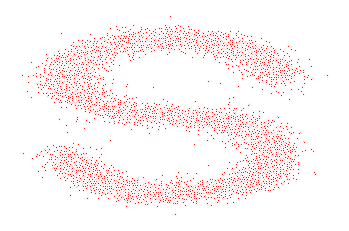

In [12]:
# Generating the forward image sequence.
imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off');

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg')
    img = Image.open(img_buf)
    imgs.append(img)

# Generating the reserve diffusion sequense
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg')
    img = Image.open(img_buf)
    reverse.append(img)

imgs = reverse

imgs[0].save("ddpm.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)

This gif shows the progress of how the picture into noise, and then reserve.  
![output](output/ddpm/ddpm.gif)